In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
from fastbook import *

import ds_omniglot
import ds_sigcomp2009
import ds_mnist
import ds_cedar

from dataset_siamese import *
from dl_models import *
from tools import *
from embeddings import *

/home/marian/anaconda3/envs/ml/lib/python3.8/site-packages/fastbook/__init__.py:19: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [2]:
import gc
gc.collect()
torch.cuda.empty_cache()

# Paths

In [2]:
path_omniglot = Path('./omniglot')

path_sigcomp = Path('./sigcomp2009')

path_cedar = Path('./full_org')

path_mnist = untar_data(URLs.MNIST)

# Datasets

In [39]:
train_ds, valid_ds = calc_dss(path_omniglot, 
                              get_image_files, 
                              ds_omniglot.get_x, 
                              ds_omniglot.get_y, 
                              ds_omniglot.is_validation)

32460 files loaded.
19280 training samples / 13180 validation samples


In [40]:
train_ds, valid_ds = calc_dss(path_sigcomp,
                              ds_sigcomp2009.get_authentic_signatures,
                              ds_sigcomp2009.get_x, 
                              ds_sigcomp2009.get_y, 
                              ds_sigcomp2009.is_test)

1000 files loaded.
60 training samples / 940 validation samples


In [55]:
train_ds, valid_ds = calc_dss(path_cedar, 
                              get_image_files,
                              ds_cedar.get_x, 
                              ds_cedar.get_y, 
                              ds_cedar.is_validation)

1320 files loaded.
1056 training samples / 264 validation samples


In [3]:
train_ds, valid_ds = calc_dss(path_mnist, 
                              get_image_files,
                              ds_mnist.get_x, 
                              ds_mnist.get_y, 
                              ds_mnist.is_validation)

70000 files loaded.
55165 training samples / 14835 validation samples


# Stats

In [5]:
fns_omniglot_train = get_image_files(path_omniglot/'images_background')
fns_omniglot_test  = get_image_files(path_omniglot/'images_evaluation')

omniglot_stats = get_stats(fns_omniglot_train, ds_omniglot.get_x, n_sample='all')
omniglot_stats

TypeError: expected Tensor as element 0 in argument 0, but got PILImageBW

In [8]:
fns_mnist          = get_image_files_truncated(10000)(path_mnist)

mnist_stats = get_stats(fns_mnist, get_x_mnist, n_sample='all')
mnist_stats

(TensorImageBW(36.8690), TensorImageBW(89.6788))

In [9]:
fns_sigcomp_train  = get_originals_train(path_sigcomp_train)

sigcomp_train_stats = get_stats(fns_sigcomp_train, get_x_sigcomp2009, n_sample='all')
sigcomp_train_stats

(TensorImageBW(0.0594), TensorImageBW(0.2364))

In [ ]:
stats = 0.0780, 0.2681 # omniglot

In [ ]:
stats = 36.8690, 89.6788 # mnist

In [ ]:
stats = 0.0594, 0.2364 # sigcomp2009

# DataLoaders

In [4]:
bs = 128

In [41]:
bs = 32

In [ ]:
stats = imagenet_stats

In [6]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=bs, 
    after_item=[Resize(224), ToTensor],  
    after_batch=[IntToFloatTensor, Normalize.from_stats(*stats)])

In [29]:
dls=dls.cuda()

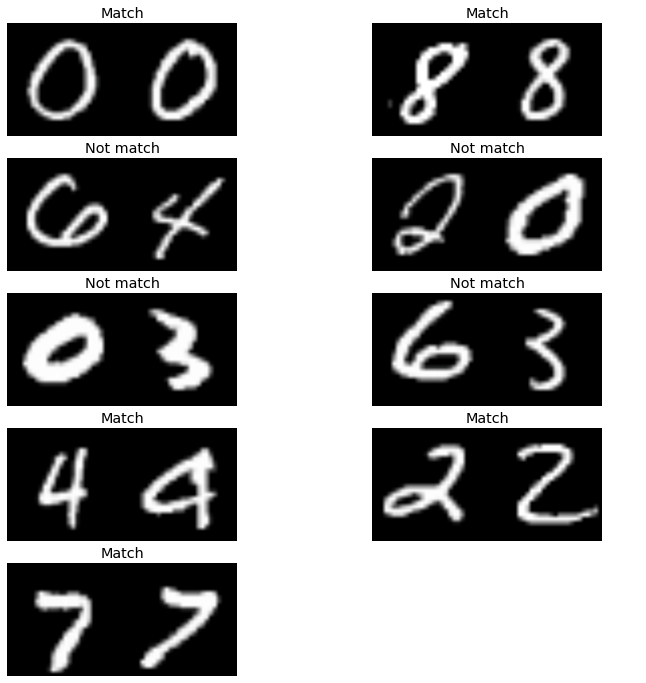

In [7]:
dls.show_batch()

In [44]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=bs, 
    after_item=[Resize(224), ToTensor],  
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

b=dls.one_batch()
len(b), b[0].shape, b[1].shape,  b[2].shape,

(3,
 torch.Size([32, 3, 224, 224]),
 torch.Size([32, 3, 224, 224]),
 torch.Size([32]))

# Model

In [9]:
loss = nn.BCEWithLogitsLoss()
metric = accuracy_multi
m = SiameseModelNN(resnet18)

In [ ]:
loss = functools.partial(my_loss_func_LeCun, margin=margin)
metric = accuracy_dist
m = SiameseModelWithDistance(resnet18, nn.PairwiseDistance(p=2)).cuda()

In [ ]:
m = torch.load(fn_model)

In [10]:
m = m.cpu()

In [ ]:
m = m.cuda()

In [10]:
test_model(m, dls)

t1.shape = torch.Size([128, 3, 224, 224]) t2.shape = torch.Size([128, 3, 224, 224])
encoder(t1).shape = torch.Size([128, 512, 7, 7]) encoder(t2).shape = torch.Size([128, 512, 7, 7])
target.shape = torch.Size([128])


RuntimeError: running_mean should contain 2048 elements not 4096

# Learner

In [12]:
l = Learner(dls, m, loss_func = loss, metrics = metric, splitter = type(m).splitter)

# Train Learner

In [14]:
l.freeze()

KeyboardInterrupt: 

In [ ]:
l.unfreeze()

In [ ]:
l.lr_find()

In [10]:
l.fit_one_cycle(3,0.033)

epoch,train_loss,valid_loss,accuracy_dist,time
0,0.253449,0.203669,0.892299,01:45
1,0.134888,0.173268,0.909598,01:45
2,0.100322,0.150143,0.930235,01:44


In [11]:
preds,targs = l.get_preds()

/home/jupyter/siamess/models.py:87: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  xs = torch.linspace(x0,xf)


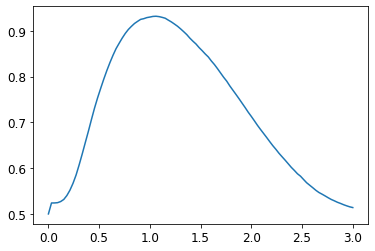

In [12]:
thresh_finder(preds, targs, accuracy_dist, 0,3)

In [16]:
accuracy_dist(preds, targs, thresh=1)

TensorImageBW(0.9149)

In [17]:
torch.save(l.model,"omniglot_distance.pt")

# Evaluate learner

In [47]:
learn.loss_func = my_loss_func_LeCun

In [71]:
interp = Interprete(learn)
interp.set_dl(dls.valid, ds_valid)

In [72]:
interp.stats()

Accuracy: 0.9288315773010254
Error rate: 0.0711684376001358
False Aceptation Ratio: 0.04465098679065704
False Rejection Ratio: 0.02651745080947876


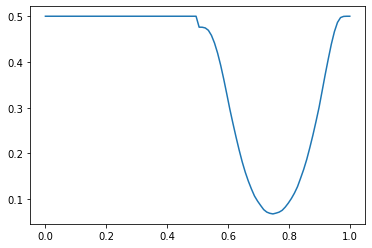

In [53]:
# Para NN Siamess
thresh_finder(interp.act, interp.y, accuracy_multi, 0, 1)

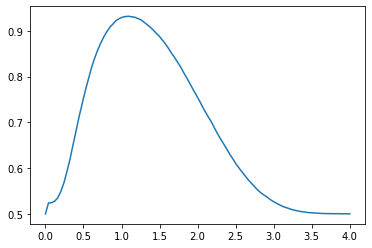

In [73]:
# Para Dist Siamess
thresh_finder(interp.act, interp.y, accuracy_dist, 0, 4)

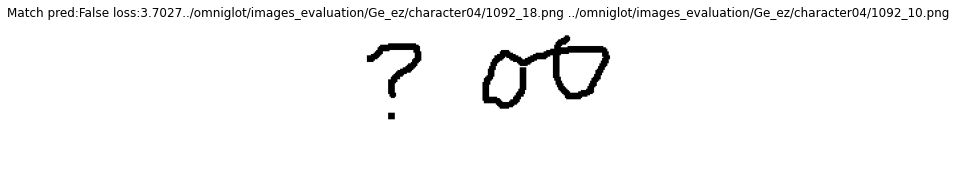

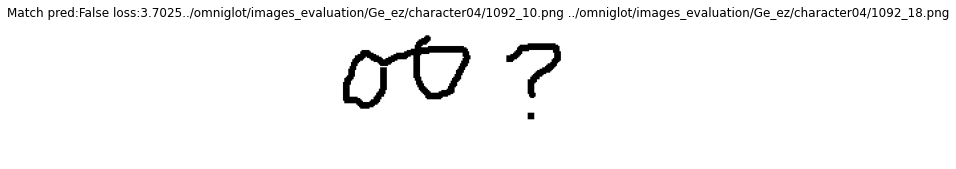

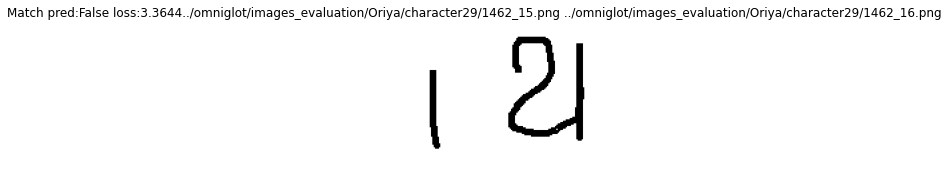

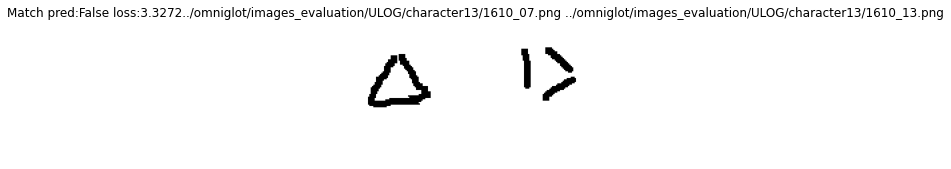

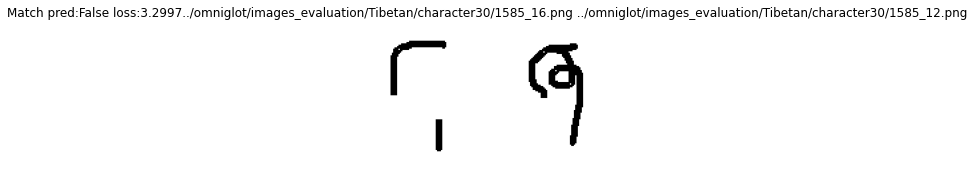

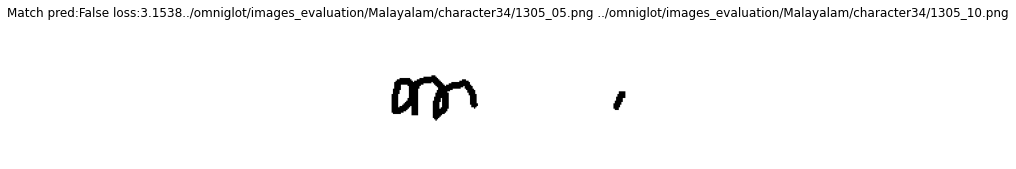

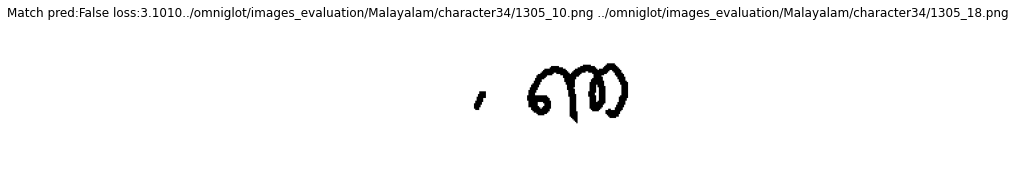

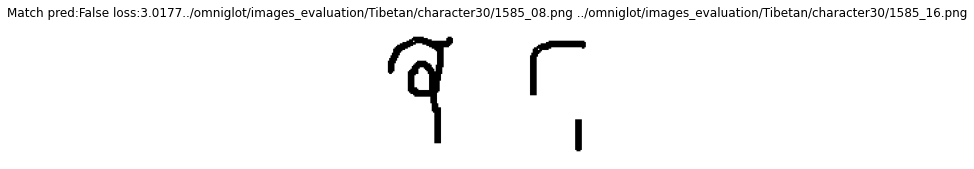

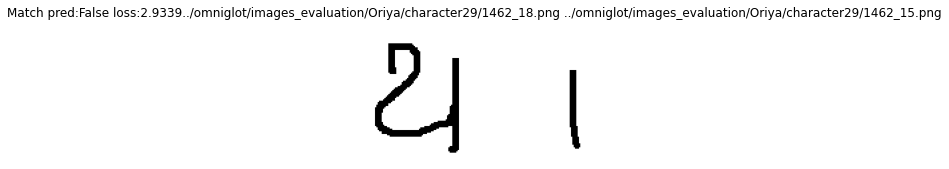

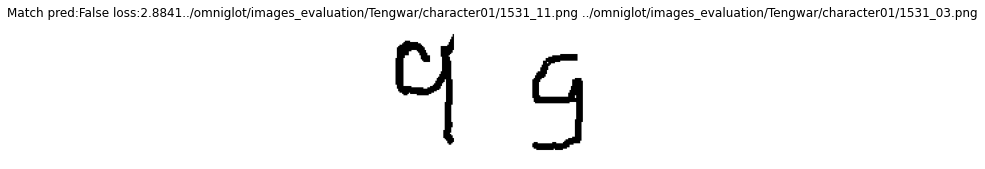

In [77]:
top_loss(interp.ids, interp.pred, interp.y, interp.loss, interp.ds, fn_info=True, kind='frr',limit=10)

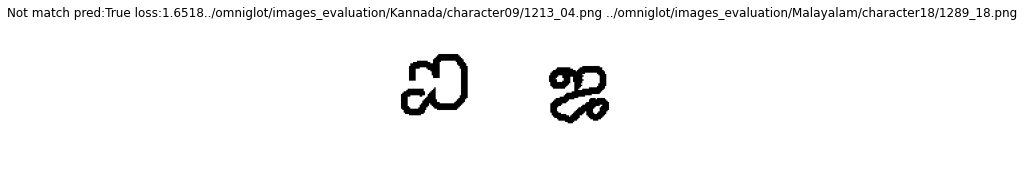

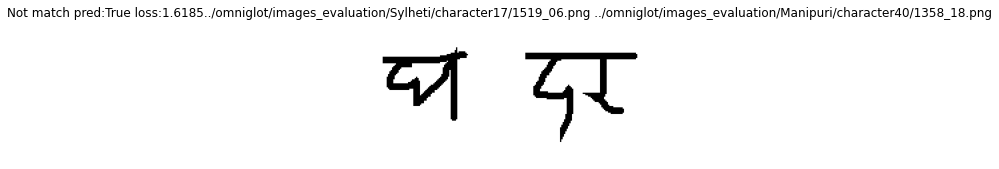

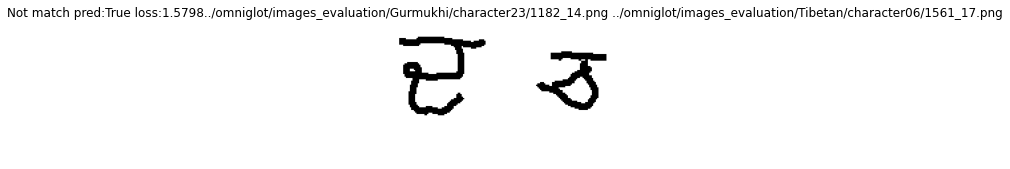

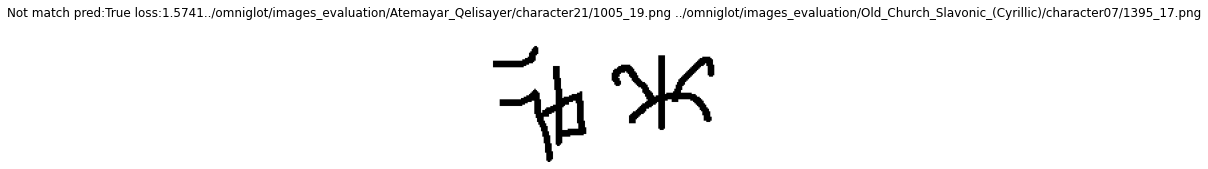

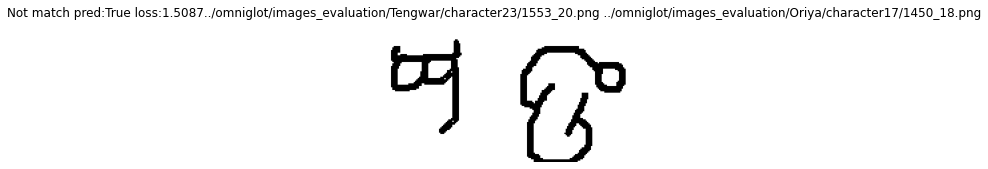

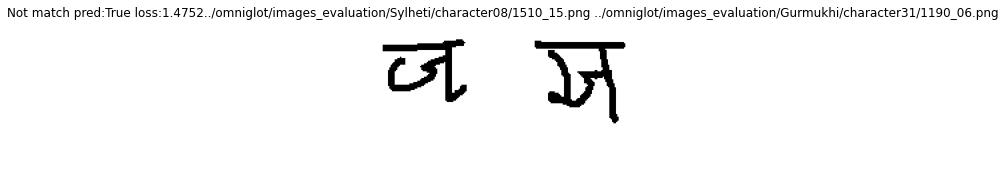

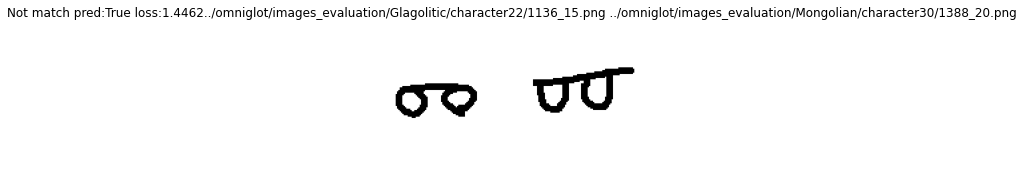

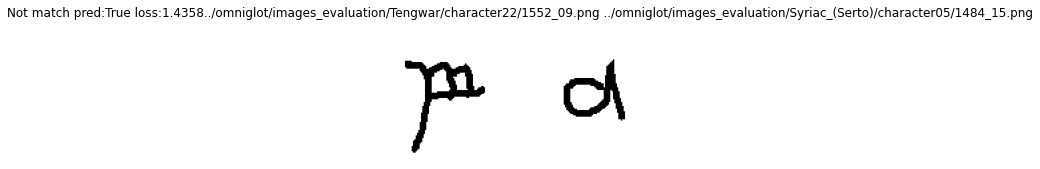

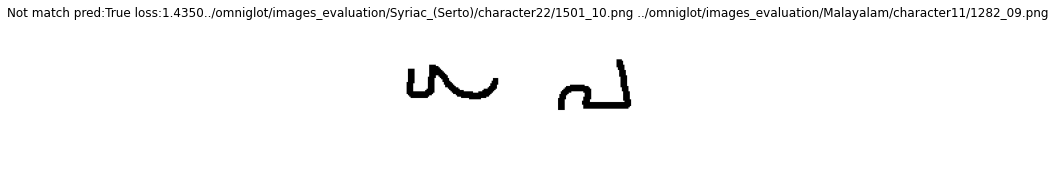

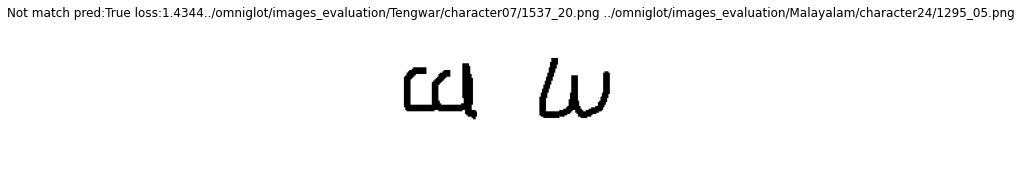

In [78]:
top_loss(interp.ids, interp.pred, interp.y, interp.loss, interp.ds, fn_info=True, kind='far',limit=10)

# Visualizing

In [80]:
fns_omniglot_train = get_image_files(path_omniglot/'images_background')
fns_omniglot_test  = get_image_files(path_omniglot/'images_evaluation')
fns_mnist          = get_image_files_truncated(10000)(path_mnist)
fns_sigcomp_train  = get_originals_train(path_sigcomp_train)

In [73]:
omniglot_stats = 0.0780, 0.2681
mnist_stats = 36.8690, 89.6788
sigcomp_train_stats = 0.0594, 0.2364

In [7]:
# Single DS omniglot train
tsfm = transforms.Normalize(*omniglot_stats)
sds_train  = SingleDS(fns_omniglot_train, get_x_omniglot, get_y_omniglot, tsfm)
e = Embeddings(sds_train, 'omniglot_train')

In [81]:
# Single DS omniglot valid
tsfm = transforms.Normalize(*omniglot_stats)
sds_valid  = SingleDS(fns_omniglot_test, get_x_omniglot, get_y_omniglot, tsfm)
e = Embeddings(sds_valid, 'omniglot_valid')

In [15]:
# Single DS MNIST
tsfm = transforms.Normalize(*mnist_stats)
sds_mnist  = SingleDS(fns_mnist, get_x_mnist, get_y_mnist, tsfm)
e = Embeddings(sds_mnist, 'mnist')

In [26]:
# Single DS Sigcomp2009 train
tsfm = transforms.Normalize(*sigcomp_train_stats)
sds_sigcomp_train  = OmniglotDS(fns_sigcomp_train, get_x_sigcomp2009, get_y_sigcomp2009_train, tsfm)
e = Embeddings(sds_sigcomp_train, 'sigcomp_train')

In [82]:
e.save()

embeddings-omniglot_valid.pt saved


In [83]:
e.xs,e.ys = get_embeddings(e.dl, learn.model)
e.save()

100%|██████████| 52/52 [00:11<00:00,  4.52it/s]


embeddings-omniglot_valid.pt saved


In [84]:
xs_pca2d = e.xs.pca(2)

/home/jupyter/siamess/tools.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax.set_prop_cycle('color', [cm(1.*i/n_cls) for i in range(n_cls)])


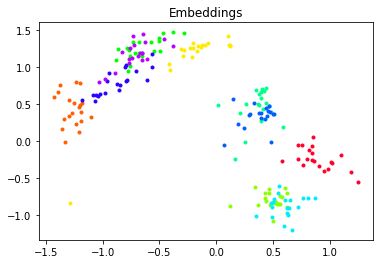

In [85]:
plotpca2d(xs_pca2d.cpu(), e.ys.cpu(),0,10)

In [86]:
xs_pca3d = e.xs.pca(3)

/home/jupyter/siamess/tools.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax.set_prop_cycle('color', [cm(1.*i/n_cls) for i in range(n_cls)])


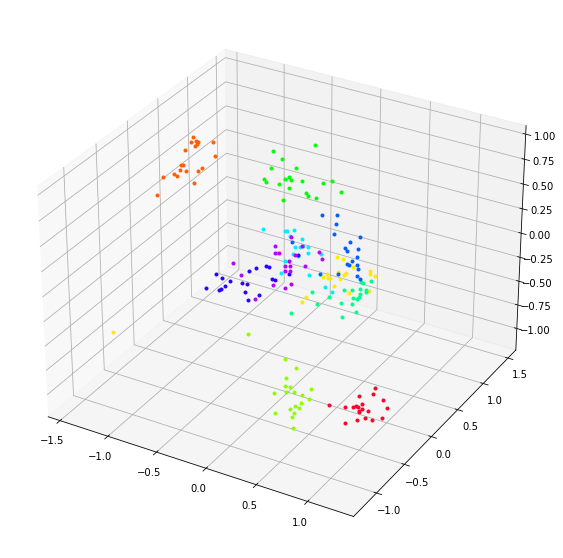

In [87]:
plotpca3d(xs_pca3d.cpu(), e.ys.cpu(),0,10)

# Fiesta!

In [3]:
e = torch.load('embeddings-omniglot_train.pt')

In [ ]:
e = torch.load('embeddings-omniglot_train_limited.pt')

In [83]:
len(set(e.ys.tolist()))

12

In [84]:
e.ys.shape

torch.Size([240])

In [88]:
msk = e.ys < 12
e.xs = e.xs[msk]
e.ys = e.ys[msk]
torch.save(e,'embeddings-omniglot_valid_limited.pt')

In [89]:
e.xs[0].tolist()

[0.0,
 0.0,
 0.0,
 0.23272711038589478,
 0.11677700281143188,
 0.0,
 0.0,
 0.7423693537712097,
 0.0,
 0.0,
 0.0,
 1.1818338632583618,
 0.0,
 0.0,
 0.060003168880939484,
 0.7849718332290649,
 1.345892310142517,
 0.8426313996315002,
 0.0,
 0.0,
 1.6863460540771484,
 1.114674687385559,
 0.7760608196258545,
 0.0,
 1.2255563735961914,
 0.09605327993631363,
 0.33299335837364197,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.1840492486953735,
 1.6732556819915771,
 0.6719347834587097,
 0.0,
 2.4837613105773926,
 4.057981491088867,
 2.9566123485565186,
 0.9490383267402649,
 2.053257942199707,
 4.22567081451416,
 3.345395803451538,
 0.7846447825431824,
 0.20362161099910736,
 1.4868500232696533,
 1.7812777757644653,
 0.45970478653907776,
 1.047773003578186,
 0.749845564365387,
 1.145466923713684,
 1.068076729774475,
 1.786582112312317,
 1.6052289009094238,
 2.6727945804595947,
 1.3285210132598877,
 2.3640072345733643,
 2.1927623748779297,
 3.5060153007507324,
 2.4773950576782227,
 2.122642993927002,
 2.404019

In [3]:
def distances(x,y):
    mm = (x @ y.t())
    return (mm.diag().unsqueeze(0) - 2*mm + mm.diag().unsqueeze(1))

In [89]:
dmat=torch.cdist(e.xs,e.xs,p=2,compute_mode='use_mm_for_euclid_dist')
dmat.shape

torch.Size([240, 240])

In [90]:
n = dmat.shape[0]
n

240

In [91]:
i = 12
j = 65

In [92]:
torch.cdist(e.xs[i].unsqueeze(0),e.xs[j].unsqueeze(0)).item(), dmat[i,j], dmat[j,i]

(1.8695935010910034,
 TensorImageBW(1.8695, device='cuda:0'),
 TensorImageBW(1.8695, device='cuda:0'))

In [93]:
class SiameseDatasetAllPairsTensor(torch.utils.data.Dataset):
    """ Generic dataset for siamese image match problem (NOT USED, very slow) """
    def __init__(self, xs, ys): self.xs, self.ys, self.n = xs, ys, xs.shape[0]

    def __getitem__(self, idx):
        i     = idx // self.n
        j     = idx %  self.n
        return ( self.xs[i], self.xs[j], (self.ys[i]==self.ys[j]).float() )

    def __len__(self): return self.n*self.n

In [95]:
dsall = SiameseDatasetAllPairsTensor(nn.Unflatten(1,(512,4,4))(e.xs),e.ys)

In [95]:
dsall = SiameseDatasetAllPairsTensor(e.xs,e.ys)

In [96]:
import torch.utils.data

dlall = torch.utils.data.DataLoader(dsall, batch_size=256)

In [97]:
with torch.no_grad():
    loss_func = nn.BCEWithLogitsLoss(reduction='none')
    acts=[]
    preds=[]
    loss=[]
    for b in tqdm(dlall):
        fts = torch.cat([b[0],b[1]], dim=1)
        act = learn.model.head(fts).squeeze()
        pred = act.sigmoid()>0.5
        l = loss_func(act,b[2])
        acts.append(act)
        preds.append(pred)
        loss.append(l)

100%|██████████| 225/225 [00:03<00:00, 57.16it/s]


In [97]:
with torch.no_grad():
    acts=[]
    preds=[]
    loss=[]
    for b in tqdm(dlall):
        act = learn.model.distance_fn(b[0],b[1])
        pred = act<1
        l = learn.loss_func(act,b[2],reduction='none')
        acts.append(act)
        preds.append(pred)
        loss.append(l)

100%|██████████| 225/225 [00:04<00:00, 55.55it/s]


In [98]:
acts=torch.cat(acts)
loss=torch.cat(loss)
preds=torch.cat(preds)
acts.shape, loss.shape, preds.shape, 

(torch.Size([57600]), torch.Size([57600]), torch.Size([57600]))

In [99]:
acts=acts.view(n,n)
loss=loss.view(n,n)
preds=preds.view(n,n)

In [100]:
n*n

57600

In [101]:
acts.shape

torch.Size([240, 240])

In [102]:
ismatch = e.ys.unsqueeze(0)==e.ys.unsqueeze(1)
ismatch.shape

torch.Size([240, 240])

In [103]:
ismatch.float().sum(), n*n-ismatch.float().sum()

(tensor(4800., device='cuda:0'), tensor(52800., device='cuda:0'))

In [106]:
d=dmat[ismatch]
l=loss[ismatch]

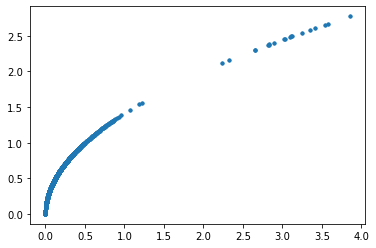

In [107]:

fig = plt.figure()
ax =  plt.axes()

plt.plot(l.cpu(),d.cpu(), '.')

In [44]:
i = 0
j = 1

In [65]:
np.correlate(l.cpu().data.numpy(), d.cpu().data.numpy())

array([706462.4], dtype=float32)

In [45]:
(e.ys[i]==e.ys[j]),  ismatch[i,j], ismatch[j,i]

(tensor(True, device='cuda:0'),
 tensor(True, device='cuda:0'),
 tensor(True, device='cuda:0'))

In [55]:
def argsort2d(t, descending=False):
    m = t.shape[1]
    t = t.flatten().argsort(descending=descending)
    return t//m, t%m
t=tensor([[13,465],[15,97]])
argsort2d(t)

(tensor([0, 1, 1, 0]), tensor([0, 0, 1, 1]))

In [56]:
len(set(e.ys.tolist()))

964

In [11]:
idx=d.flatten().argsort(descending=True)[:3]

In [13]:
f_pca.shape[0]

torch.Size([13120, 2])

In [109]:
mm.diag().unsqueeze(1).t().shape

torch.Size([13120, 1])

In [74]:
math.sqrt( (f_pca[0]-f_pca[1])@(f_pca[0]-f_pca[1]).t() )

10.966543470191223

In [70]:
f_pca[0].unsqueeze(0).shape

torch.Size([1, 2])

In [78]:
F.pairwise_distance(f_pca,f_pca)

TensorImageBW([1.4142e-06, 1.4142e-06, 1.4142e-06,  ..., 1.4142e-06, 1.4142e-06, 1.4142e-06], device='cuda:0')

In [4]:
d=distances( f_pca , f_pca)
d.shape

torch.Size([13120, 13120])

In [112]:
idx=d.flatten().argsort(descending=True)[:3].cpu()
idx

TensorImageBW([16, 15,  4])

In [28]:
d.max()

TensorImageBW(3933.1084, device='cuda:0')

In [6]:
same_class = y_final.unsqueeze(0)==y_final.unsqueeze(1)
same_class

TensorCategory([[ True, False, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        ...,
        [False, False, False,  ...,  True, False, False],
        [False, False, False,  ..., False,  True, False],
        [False, False, False,  ..., False, False,  True]], device='cuda:0')

In [11]:
n_matches = same_class.sum()
n_unmatches = same_class.shape[0]*same_class.shape[0] - n_matches
n_matches, n_unmatches

(TensorCategory(261264, device='cuda:0'),
 TensorCategory(171873136, device='cuda:0'))

In [22]:
n_matches*n_matches-same_class.shape[0]*10

TensorCategory(68258746496, device='cuda:0')

In [23]:
d_same,_ = torch.kthvalue(d[same_class], n_matches-same_class.shape[0]*10)
d_same

TensorImageBW(195.7053, device='cuda:0')

In [24]:
d_diff,_ = torch.kthvalue(d[~same_class], same_class.shape[0]*10)
d_diff

TensorImageBW(3.3969, device='cuda:0')

In [75]:
same_and_far = torch.nonzero(same_class & (d>=d_same))
diff_and_near = torch.nonzero(~same_class & (d<=d_diff))

In [76]:
diff_and_near

TensorCategory([[    0,   909],
        [    0,  2152],
        [    0,  2441],
        ...,
        [13119,  5940],
        [13119,  6641],
        [13119,  9628]], device='cuda:0')

In [77]:
f_pca[diff_and_near[:,0]]

TensorImageBW([[19.2743, 19.8022],
        [19.2743, 19.8022],
        [19.2743, 19.8022],
        ...,
        [62.0013, 23.1626],
        [62.0013, 23.1626],
        [62.0013, 23.1626]], device='cuda:0')

In [78]:
f_pca[diff_and_near[:,1]]

TensorImageBW([[17.9010, 19.3899],
        [17.6852, 20.5818],
        [18.2052, 20.7848],
        ...,
        [61.6282, 22.7003],
        [61.6105, 24.6663],
        [61.1291, 24.5603]], device='cuda:0')

In [79]:
import itertools

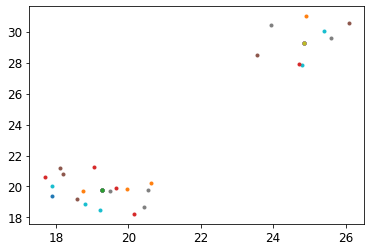

In [85]:
fig = plt.figure()  
for i, (x, y) in itertools.islice( enumerate(zip(f_pca[diff_and_near[:,0]].cpu(), f_pca[diff_and_near[:,1]].cpu())), 25):
    plt.plot(x[0], x[1], '.',label=i)
    plt.plot(y[0], y[1], '.',label=i)

ax = fig.gca()
for i, p in enumerate(ax.get_lines()):    # this is the loop to change Labels and colors
    if int(p.get_label())==(i-1):    # check for Name already exists
        idx = i-1       # find ist index
        p.set_c(ax.get_lines()[idx].get_c())   # set color
        p.set_label('_' + p.get_label())

NameError: name 'l' is not defined

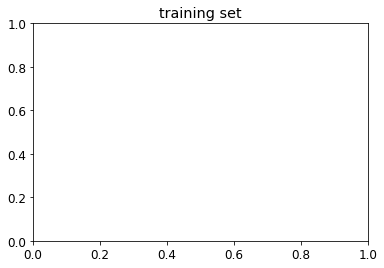

In [78]:
plt.title('training set')
for i in [15,40,20,77,88,100]:
    plt.plot(a[l==i], b[l==i], '.', label=f'class {i}')
#plt.plot(a[y_final==0][idx//20], b[y_final==0][idx//20], 'o', label=f'other')
#plt.plot(a[y_final==1][idx%20], b[y_final==1][idx%20], 'o', label=f'other')
plt.show() 

In [27]:
idx//20,idx%20

TensorImageBW([ 6, 19,  6])

In [35]:
x=f_pca[y_final==1][idx//20]
x

TensorImageBW([[-43.1183,  41.9499],
        [-43.1183,  41.9499],
        [-29.9765,  43.0367]], device='cuda:0')

In [36]:
y=f_pca[y_final==2][idx%20]
y

TensorImageBW([[ 16.4078, -36.3815],
        [ 28.9685, -16.2331],
        [ 16.4078, -36.3815]], device='cuda:0')

In [42]:
mm=x@y.t()
mm

TensorImageBW([[-2233.6760, -1930.0508, -2233.6760],
        [-2233.6760, -1930.0508, -2233.6760],
        [-2057.5845, -1566.9916, -2057.5845]], device='cuda:0')

In [118]:
idx=d[y_final==0,:][:,y_final==1].flatten().argsort()[:3]

In [110]:
maxi = 9999999999
mi = -1
mj = -1
for i,x1 in enumerate(f_pca[y_final==0]):
    for j,x2 in enumerate(f_pca[y_final==1]):
        vd=torch.cdist(x1.unsqueeze(0),x2.unsqueeze(0))
        if vd<maxi:
            maxi =vd
            mi = i
            mj=j
maxi,mi,mj
            
        

(tensor([[0.7305]], device='cuda:0'), 5, 12)

In [119]:
idx//20,idx%20

(TensorImageBW([5, 5, 7], device='cuda:0'),
 TensorImageBW([12, 15, 14], device='cuda:0'))

In [114]:
f_pca[y_final==1][idx//20]

TensorImageBW([[-20.4129,   6.8615],
        [-20.4129,   6.8615],
        [-20.4129,   6.8615]], device='cuda:0')

In [115]:
F.pairwise_distance(f_pca[y_final==0][idx//20],f_pca[y_final==1][idx%20])

TensorImageBW([82.0679, 71.5583, 78.6707], device='cuda:0')

In [65]:
learn.get_preds(dl=dls.valid, with_loss=True)

(TensorImageBW([ -3.9081,   7.4506,  -9.4083,  ...,  -1.3797, -12.3450,   4.7503]),
 tensor([0., 1., 0.,  ..., 1., 0., 1.]),
 TensorImageBW([1.9879e-02, 5.8086e-04, 8.2013e-05,  ..., 1.6042e+00, 4.4107e-06, 8.6117e-03]))

In [32]:
act,y=learn.get_preds(dl=dl_minist)
act = act.cuda()
y =y.cuda()
pred = act.sigmoid()>0.5
(pred==y).float().mean()

TensorImageBW(0.5799, device='cuda:0')

In [33]:
(pred==y).float().mean()

TensorImageBW(0.5799, device='cuda:0')

In [279]:
toacc = []
with torch.no_glearn.frad():
    for x1,x2,y in dl_minist:
        pred = learn.model(x1.cuda(),x2.cuda()).sigmoid()>0.5
        toacc.append(pred==y)
torch.cat(toacc).float().mean()
        

TensorImageBW(0.5000, device='cuda:0')

In [278]:
(pred==y).float().mean()

TensorImageBW(0.5000, device='cuda:0')

In [54]:
act, y = learn.get_preds(dl=dls.valid)
act = act.cuda()
y = y.cuda()

In [59]:
((act.sigmoid()>0.5) == y).float().mean()

TensorImageBW(0.9380, device='cuda:0')

In [46]:
y=torch.cat([b[2] for b in dls.valid])
y

tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')

In [36]:
accuracy_multi??

In [239]:
len(train_ds)/100*7

2699.2000000000003

In [185]:
tact, ty, loss = learn.get_preds(dl=dls.valid, with_loss=True)
tids = torch.argsort(loss,descending=True)

In [194]:
tact = (tact.sigmoid()>0.5)

In [195]:
tact

TensorImageBW([False,  True, False,  ..., False, False,  True])

In [186]:
loss.shape

torch.Size([26360])

In [144]:
tdl = DataLoader(train_ds,bs=256,shuffle=False, device=torch.device('cuda'))
tact, ty, loss = learn.get_preds(dl=tdl, with_loss=True)
tids = torch.argsort(loss,descending=True)


TensorImageBW([3.3373e-04, 1.4312e-02, 3.9934e-05,  ..., 6.9412e-02, 1.8516e-02, 4.2128e-02])

In [138]:
l

TensorImageBW([0.0326, 0.0020], device='cuda:0')

In [118]:
tids = torch.argsort(loss,descending=True)
tids

TensorImageBW([37547, 31867, 12085,  ..., 32662, 32672,   930])

In [188]:
loss

TensorImageBW([1.9879e-02, 5.8086e-04, 8.2013e-05,  ..., 1.6042e+00, 4.4107e-06, 8.6117e-03])

In [189]:
l

TensorImageBW([1.9879e-02, 5.8086e-04, 8.2013e-05,  ..., 1.6042e+00, 4.4107e-06, 8.6117e-03], device='cuda:0')

In [130]:
xx=[train_ds[0],train_ds[1]]

In [179]:
tmp_dl = DataLoader(valid_ds,bs=256,shuffle=False)
loss_no_reduction=nn.BCEWithLogitsLoss(reduction='none')
l = []
with torch.no_grad():
    for x1,x2,y in tmp_dl:
        prob = learn.model(x1.cuda(),x2.cuda())
        loss = loss_no_reduction(prob,y.cuda())
        l.append(loss)
len(l)

103

In [180]:
l=torch.cat(l)

In [135]:
l

TensorImageBW([0.0326, 0.0020], device='cuda:0')

In [148]:
ids = torch.argsort(l,descending=True)tact

TypeError: argsort() received an invalid combination of arguments - got (list, descending=bool), but expected one of:
 * (Tensor input, name dim, bool descending)
 * (Tensor input, int dim, bool descending)


In [63]:
ids

TensorImageBW([37547, 12107, 26026,  ..., 38372, 38386, 38460], device='cuda:0')

In [163]:
v,i=interp.top_losses(100)
i

TensorImageBW([ 4111,  4087,  4097, 10151, 23107, 15555, 10133, 10157, 15531,  4563, 23081,  4599,  6043, 23109, 15527, 17373, 13061,  4891, 15415,  2381, 19063, 16011,  9505,  4561,  2615, 24361, 15899,
        24381, 15377, 16211,  4423,  9489, 15485,  4195,  8547,   465, 10617, 15135,  7531, 13077, 15433, 21837,  9882,   633, 15633, 24485, 15251, 15133,  2203, 24491,  5501, 15249, 15131, 12097,
        15505, 15159,  9756, 11027,  4449,  9093, 15947,  8197, 24505, 16089, 16109, 23218, 22115,  2233, 24489, 12274,  4197, 15277,  4333,  3882,  4191, 25047, 15551, 13959,  5475, 11015, 16019,
        15411,  5281, 15915,   418, 13244, 10740, 19148,  2213, 26060, 16229, 19196, 19128,  9484,  5461,  3614, 21443,  4994,  5106, 21665])

In [92]:
w1 = widgets.Checkbox(
        value=False,
        description="It's wrong",
        disabled=False
    )
w2 = widgets.Checkbox(
        value=False,
        description="It's wrong",
        disabled=False
    )
widgets.VBox([w1,w2])

In [116]:
def img_w(fn):
    w = widgets.Image(value=open(fn,'rb').read(),
                      format='png',
                      width=100,
                      height=100)
    return w
def imgs_wg(fns): return widgets.Box([ img_w(fn) for fn in fns])
    

In [117]:
fns = [path/'images_evaluation/Atemayar_Qelisayer/character24/1008_18.png',
       path/'images_evaluation/Atemayar_Qelisayer/character24/1008_18.png']
imgs_wg(fns)


Box(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00i\x00\x00\x00i\x01\x00\x00\x00\x00\…

In [90]:
w1.value, w2.value

(False, True)